## Setting the environment

In [1]:
# Mounting google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Setting toolkit folder as working directory

%cd /content/drive/My Drive/Sentiment Analysis
! ls

/content/drive/My Drive/Sentiment Analysis
a1_IMDB_Dataset.csv	    c1_lstm_model_acc_0.863.h5	    c3_unseen_predictions_all_models.csv
a2_glove.6B.100d.txt	    c1_lstm_model_acc_0.869.h5	    Sentiment_Analysis.ipynb
a3_IMDb_Unseen_Reviews.csv  c2_IMDb_Unseen_Predictions.csv


In [91]:
# Importing essential libraries and functions

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score


from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

## Loading dataset

In [4]:
# Importing IMDb Movie Reviews dataset

movie_reviews = pd.read_csv("a1_IMDB_Dataset.csv")

# dataset source: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [5]:
# Dataset exploration

movie_reviews.shape

(50000, 2)

In [6]:
movie_reviews.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
# Checking for missing values

movie_reviews.isnull().values.any()

False

<Axes: xlabel='sentiment', ylabel='count'>

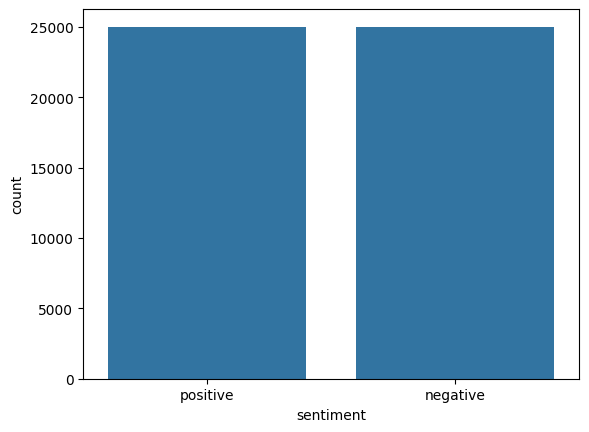

In [8]:
# Let's observe distribution of positive / negative sentiments in dataset

import seaborn as sns
sns.countplot(x='sentiment', data=movie_reviews)

## Data Preprocessing

In [9]:
movie_reviews["review"][2]

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [10]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [11]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [12]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''

    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [13]:
# Calling preprocessing_text function on movie_reviews

X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [14]:
# Sample cleaned up movie review

X[2]

# w'out embedding

'thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial killer may disappointed realize match point risk addiction thought proof woody allen still fully control style many us grown love laughed one woody comedies years dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young woman may crown jewel career wittier devil wears prada interesting superman great comedy go see friends '

In [15]:
# Converting sentiment labels to 0 & 1

y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# The train set will be used to train our deep learning models
# while test set will be used to evaluate how well our model performs

## Preparing embedding layer

In [17]:
# Embedding layer expects the words to be in numeric form
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [18]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

92394

In [19]:
# Padding all reviews to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [20]:
# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('a2_glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [21]:
# Create Embedding Matrix having 100 columns
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [22]:
embedding_matrix.shape

(92394, 100)

# Model Training with:

## Simple Neural Network

In [23]:
# Neural Network architecture

snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

snn_model.add(embedding_layer)

snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

In [24]:
# Model compiling

snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(snn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9239400   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 1)                 10001     
                                                                 
Total params: 9249401 (35.28 MB)
Trainable params: 10001 (39.07 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None


In [25]:
# Model training

snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 3s 10ms/step - loss: 0.5553 - acc: 0.7177 - val_loss: 0.5068 - val_acc: 0.7582
Epoch 2/6
250/250 [==============================] - 3s 12ms/step - loss: 0.4491 - acc: 0.7939 - val_loss: 0.5248 - val_acc: 0.7534
Epoch 3/6
250/250 [==============================] - 2s 9ms/step - loss: 0.4103 - acc: 0.8173 - val_loss: 0.5005 - val_acc: 0.7606
Epoch 4/6
250/250 [==============================] - 2s 7ms/step - loss: 0.3907 - acc: 0.8257 - val_loss: 0.5128 - val_acc: 0.7584
Epoch 5/6
250/250 [==============================] - 1s 5ms/step - loss: 0.3748 - acc: 0.8379 - val_loss: 0.5195 - val_acc: 0.7579
Epoch 6/6
250/250 [==============================] - 2s 7ms/step - loss: 0.3622 - acc: 0.8429 - val_loss: 0.5344 - val_acc: 0.7549


In [26]:
# Predictions on the Test Set

score = snn_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 1s 2ms/step - loss: 0.5616 - acc: 0.7511


In [83]:
snn_pred = snn_model.predict(X_test)
# cm = confusion_matrix(y_test,snn_pred)

313/313 [==============================] - 1s 2ms/step


In [84]:
snn_pred2 = []
for pred in snn_pred:
  if pred>0.5:
    pred = 1
  else:
    pred = 0
  snn_pred2.append(pred)

In [85]:
cm = confusion_matrix(y_test,snn_pred2)
cm

array([[3523, 1438],
       [1051, 3988]])

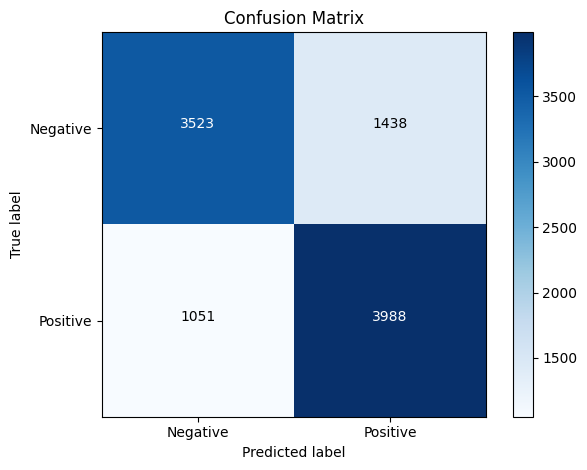

In [86]:
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Negative', 'Positive'])
plt.yticks(tick_marks, ['Negative', 'Positive'])

fmt = 'd'
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [92]:
precision = precision_score(y_test, snn_pred2)
print("Precision Score:", precision)

# Compute Recall Score
recall = recall_score(y_test, snn_pred2)
print("Recall Score:", recall)

# Compute F1-score
f1 = f1_score(y_test, snn_pred2)
print("F1-score:", f1)

Precision Score: 0.7349797272392186
Recall Score: 0.7914268704107958
F1-score: 0.7621595795508839


In [27]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.561639666557312
Test Accuracy: 0.7511000037193298


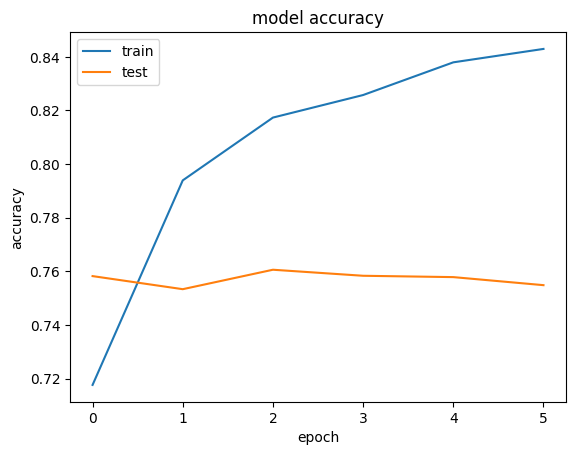

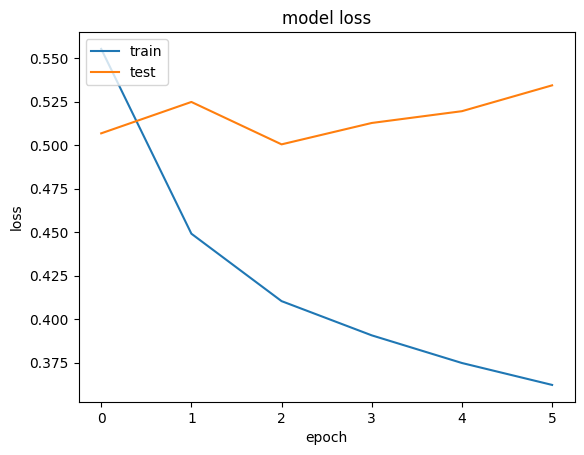

In [28]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Convolutional Neural Network

In [29]:
from keras.layers import Conv1D

In [30]:
# Neural Network architecture

cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [31]:
# Model compiling

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9303657 (35.49 MB)
Trainable params: 64257 (251.00 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None


In [32]:
# Model training

cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 29s 113ms/step - loss: 0.4795 - acc: 0.7672 - val_loss: 0.3807 - val_acc: 0.8324
Epoch 2/6
250/250 [==============================] - 27s 106ms/step - loss: 0.3420 - acc: 0.8540 - val_loss: 0.3497 - val_acc: 0.8471
Epoch 3/6
250/250 [==============================] - 26s 102ms/step - loss: 0.2860 - acc: 0.8840 - val_loss: 0.3417 - val_acc: 0.8505
Epoch 4/6
250/250 [==============================] - 29s 116ms/step - loss: 0.2401 - acc: 0.9120 - val_loss: 0.3322 - val_acc: 0.8543
Epoch 5/6
250/250 [==============================] - 27s 109ms/step - loss: 0.1995 - acc: 0.9324 - val_loss: 0.3320 - val_acc: 0.8549
Epoch 6/6
250/250 [==============================] - 27s 106ms/step - loss: 0.1644 - acc: 0.9502 - val_loss: 0.3355 - val_acc: 0.8549


In [33]:
# Predictions on the Test Set

score = cnn_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 4s 11ms/step - loss: 0.3377 - acc: 0.8553


In [34]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3377143144607544
Test Accuracy: 0.8553000092506409


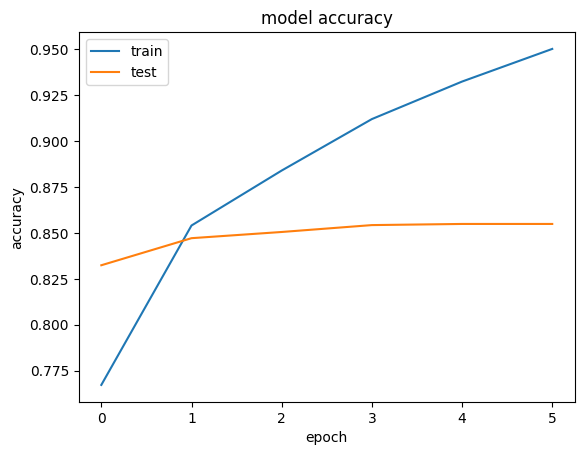

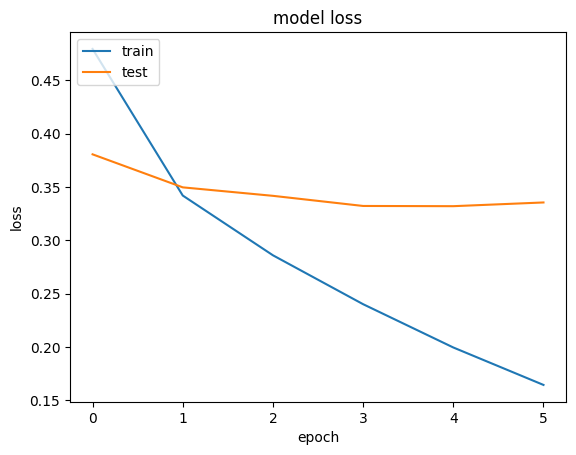

In [35]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

313/313 [==============================] - 8s 27ms/step


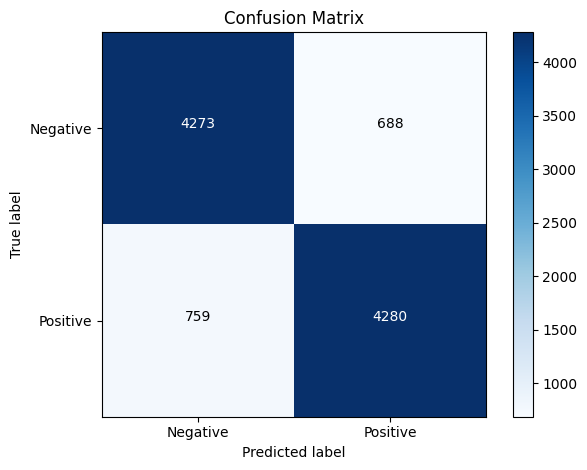

In [82]:
cnn_pred = cnn_model.predict(X_test)
cnn_pred2 = []
for pred in cnn_pred:
  if pred>=0.5:
    pred = 1
  else:
    pred = 0
  cnn_pred2.append(pred)
cm = confusion_matrix(y_test,cnn_pred2)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Negative', 'Positive'])
plt.yticks(tick_marks, ['Negative', 'Positive'])

fmt = 'd'
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [93]:
precision = precision_score(y_test, cnn_pred2)
print("Precision Score:", precision)

# Compute Recall Score
recall = recall_score(y_test, cnn_pred2)
print("Recall Score:", recall)

# Compute F1-score
f1 = f1_score(y_test, cnn_pred2)
print("F1-score:", f1)

Precision Score: 0.8615136876006442
Recall Score: 0.8493748759674539
F1-score: 0.8554012191465974


## Recurrent Neural Network (LSTM)

In [36]:
from keras.layers import LSTM

In [37]:
# Neural Network architecture

lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

In [38]:
# Model compiling

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9356777 (35.69 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None


In [39]:
# Model Training

lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 154s 601ms/step - loss: 0.5005 - acc: 0.7608 - val_loss: 0.4924 - val_acc: 0.7897
Epoch 2/6
250/250 [==============================] - 124s 496ms/step - loss: 0.4099 - acc: 0.8169 - val_loss: 0.3869 - val_acc: 0.8336
Epoch 3/6
250/250 [==============================] - 100s 400ms/step - loss: 0.3715 - acc: 0.8394 - val_loss: 0.3469 - val_acc: 0.8514
Epoch 4/6
250/250 [==============================] - 128s 514ms/step - loss: 0.3486 - acc: 0.8506 - val_loss: 0.3415 - val_acc: 0.8555
Epoch 5/6
250/250 [==============================] - 88s 353ms/step - loss: 0.3290 - acc: 0.8607 - val_loss: 0.3202 - val_acc: 0.8655
Epoch 6/6
250/250 [==============================] - 89s 354ms/step - loss: 0.3081 - acc: 0.8720 - val_loss: 0.3191 - val_acc: 0.8669


In [40]:
# Predictions on the Test Set

score = lstm_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 21s 68ms/step - loss: 0.3293 - acc: 0.8629


In [41]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.32930365204811096
Test Accuracy: 0.8629000186920166


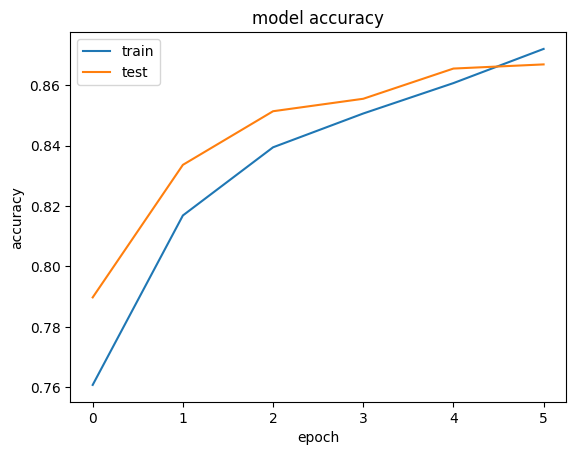

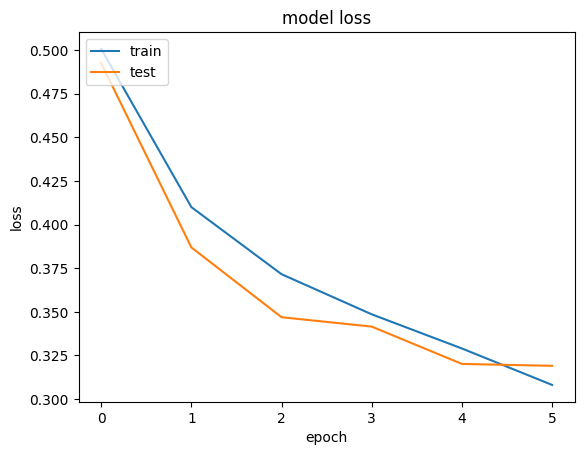

In [42]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

313/313 [==============================] - 21s 66ms/step


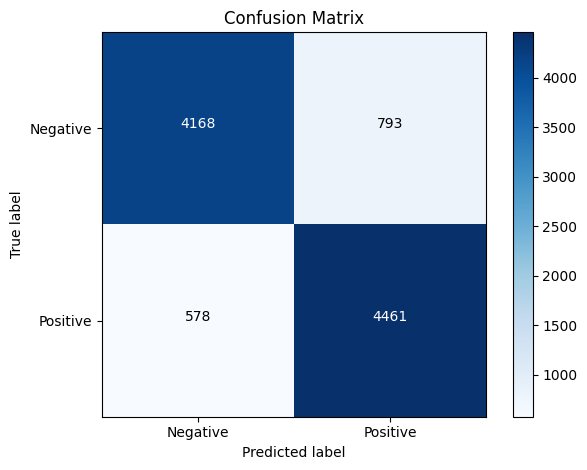

In [90]:
lstm_pred = lstm_model.predict(X_test)
lstm_pred2 = []
for pred in lstm_pred:
  if pred>=0.5:
    pred = 1
  else:
    pred = 0
  lstm_pred2.append(pred)
cm = confusion_matrix(y_test,lstm_pred2)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Negative', 'Positive'])
plt.yticks(tick_marks, ['Negative', 'Positive'])

fmt = 'd'
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [94]:
precision = precision_score(y_test, lstm_pred2)
print("Precision Score:", precision)

# Compute Recall Score
recall = recall_score(y_test, lstm_pred2)
print("Recall Score:", recall)

# Compute F1-score
f1 = f1_score(y_test, lstm_pred2)
print("F1-score:", f1)

Precision Score: 0.8490673772363914
Recall Score: 0.8852947013296288
F1-score: 0.8668026814339842


In [43]:
# Saving the model as a h5 file for possible use later

lstm_model.save(f"./c1_lstm_model_acc_{round(score[1], 3)}.h5", save_format='h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Making Predictions on Live IMDb data

In [44]:
!ls # lists files in working directory

a1_IMDB_Dataset.csv	    c1_lstm_model_acc_0.863.h5	    c3_unseen_predictions_all_models.csv
a2_glove.6B.100d.txt	    c1_lstm_model_acc_0.869.h5	    Sentiment_Analysis.ipynb
a3_IMDb_Unseen_Reviews.csv  c2_IMDb_Unseen_Predictions.csv


In [45]:
# # Load previously trained LSTM Model

# from keras.models import load_model

# model_path ='./c1_lstm_model_acc_0.856.h5'
# pretrained_lstm_model = load_model(model_path)

# # summarize model.
# pretrained_lstm_model.summary()

In [46]:
# Load sample IMDb reviews csv, having ~6 movie reviews, along with their IMDb rating

sample_reviews = pd.read_csv("a3_IMDb_Unseen_Reviews.csv")

sample_reviews.head(6)

,Unnamed: 0,Movie,Review Text,IMDb Rating
0,0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9
1,1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10
2,2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3
3,3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1
4,4,Eternals,Amazing visuals and philosophical concepts!\n\...,10
5,5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3


In [47]:
# Preprocess review text with earlier defined preprocess_text function

unseen_reviews = sample_reviews['Review Text']

unseen_processed = []
for review in unseen_reviews:
  review = preprocess_text(review)
  unseen_processed.append(review)

In [48]:
# Tokenising instance with earlier trained tokeniser
unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)

# Pooling instance to have maxlength of 100 tokens
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)

In [49]:
# Passing tokenised instance to the LSTM model for predictions
unseen_sentiments = lstm_model.predict(unseen_padded)

unseen_sentiments

1/1 [==============================] - 1s 1s/step


array([[0.92866397],
       [0.9954048 ],
       [0.1646277 ],
       [0.9248468 ],
       [0.9787651 ],
       [0.01541023]], dtype=float32)

In [50]:
# Writing model output file back to Google Drive

sample_reviews['Predicted Sentiments'] = np.round(unseen_sentiments*10,1)

df_prediction_sentiments = pd.DataFrame(sample_reviews['Predicted Sentiments'], columns = ['Predicted Sentiments'])
df_movie                 = pd.DataFrame(sample_reviews['Movie'], columns = ['Movie'])
df_review_text           = pd.DataFrame(sample_reviews['Review Text'], columns = ['Review Text'])
df_imdb_rating           = pd.DataFrame(sample_reviews['IMDb Rating'], columns = ['IMDb Rating'])


dfx=pd.concat([df_movie, df_review_text, df_imdb_rating, df_prediction_sentiments], axis=1)

dfx.to_csv("./c2_IMDb_Unseen_Predictions.csv", sep=',', encoding='UTF-8')

dfx.head(6)

,Movie,Review Text,IMDb Rating,Predicted Sentiments
0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9,9.3
1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10,10.0
2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3,1.6
3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1,9.2
4,Eternals,Amazing visuals and philosophical concepts!\n\...,10,9.8
5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3,0.2


In [51]:
lstm_predictions = lstm_model.predict(unseen_padded)
cnn_predictions = cnn_model.predict(unseen_padded)
snn_predictions = snn_model.predict(unseen_padded)

1/1 [==============================] - 0s 116ms/step


In [52]:

sample_reviews['LSTM Predictions'] = np.round(lstm_predictions*10,1)
sample_reviews['CNN Predictions'] = np.round(cnn_predictions*10,1)
sample_reviews['SNN Predictions'] = np.round(snn_predictions*10,1)

df_LSTM_predictions = pd.DataFrame(sample_reviews['LSTM Predictions'], columns = ['LSTM Predictions'])
df_CNN_Predictions = pd.DataFrame(sample_reviews['CNN Predictions'], columns = ['CNN Predictions'])
df_SNN_predictions = pd.DataFrame(sample_reviews['SNN Predictions'], columns = ['SNN Predictions'])
df_movie                 = pd.DataFrame(sample_reviews['Movie'], columns = ['Movie'])
df_review_text           = pd.DataFrame(sample_reviews['Review Text'], columns = ['Review Text'])
df_imdb_rating           = pd.DataFrame(sample_reviews['IMDb Rating'], columns = ['IMDb Rating'])


dfx=pd.concat([df_movie, df_review_text, df_imdb_rating, df_LSTM_predictions,df_CNN_Predictions,df_SNN_predictions], axis=1)

dfx.to_csv("c3_unseen_predictions_all_models.csv", sep=',', encoding='UTF-8')

dfx.head(6)

,Movie,Review Text,IMDb Rating,LSTM Predictions,CNN Predictions,SNN Predictions
0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9,9.3,9.5,2.3
1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10,10.0,9.8,8.4
2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3,1.6,0.1,0.4
3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1,9.2,1.3,9.0
4,Eternals,Amazing visuals and philosophical concepts!\n\...,10,9.8,9.5,9.9
5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3,0.2,1.1,8.0


[[32471   121   100 ...    96   232  3671]
 [  299    33    83 ...    22  1545    27]
 [ 1173    35     9 ...     0     0     0]
 ...
 [  648     3   259 ...     0     0     0]
 [  234    78   706 ...     0     0     0]
 [  402     1   144 ...     0     0     0]]
